## Predict Future Sales (Time Series)

Kaggle Competition

**Goal**: Predict total sales for every product and store for November 2015. <br>
**Data Given**: Daily historical data from January 2013 to October 2015. <br>

#### 1. Import packages and data

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats

# Visualistion
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

In [79]:
# Import all of them 
sales=pd.read_csv("sales_train.csv")
item_cat=pd.read_csv("item_categories-translated.csv")
item=pd.read_csv("items-translated.csv")
sub=pd.read_csv("sample_submission.csv")
shops=pd.read_csv("shops-translated.csv")
test=pd.read_csv("test.csv")

Thanks to deargle who translated the Russian to English. <br>
https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/discussion/54949

#### 2. Compress data size

In [80]:
def downcast_dtypes(df, verbose = True):
    start_mem = df.memory_usage().sum() / 1024**2
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

sales = downcast_dtypes(sales, verbose = True)
print(sales.info())

Mem. usage decreased to 61.60 Mb (54.2% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


The data is now much lighter!!

#### 3. Data Structure

In [9]:
# Check Null values
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Great, there is no missing values.

In [10]:
# Check how many rows & columns
sales.shape

(2935849, 6)

Almost 3 miliion rows of data.

In [14]:
# check duplicates
sales[sales.duplicated()]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-01-05,0,54,20130,149.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671873,2014-05-01,16,50,3423,999.0,1.0
1866340,2014-07-12,18,25,3423,999.0,1.0
2198566,2014-12-31,23,42,21619,499.0,1.0


Nothing much to worry about for the duplicates, might be just the same purchase in the same shop from different people.

#### 4. Feature Extraction

##### 4.1 Convert 'date' column to datetime format for future extraction purpose.

In [19]:
## Before converting date to datetime format
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [66]:
# convert date to datetime format
# sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
sales.date = pd.to_datetime(sales.date, format = '%d.%m.%Y')
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
 6   revenue         float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 156.8 MB
None


In [21]:
## After converting date to datetime format
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.000000,1.0
1,2013-01-03,0,25,2552,899.000000,1.0
2,2013-01-05,0,25,2552,899.000000,-1.0
3,2013-01-06,0,25,2554,1709.050049,1.0
4,2013-01-15,0,25,2555,1099.000000,1.0


##### 4.2 Calculate sales revenue

In [63]:
sales['revenue'] = sales.item_price.values * sales.item_cnt_day.values

In [64]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [43]:
# Number of returns
len(sales[sales.item_cnt_day < 0])

7356

##### 4.3 Split year, month and day in each column

In [46]:
sales['month'] = sales.date.dt.month
sales['year'] = sales.date.dt.year
sales['day_of_week'] = sales.date.dt.day_of_week

In [47]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,reveunue,month,year,day_of_week
0,2013-01-02,0,59,22154,999.000000,1.0,999.000000,1,2013,2
1,2013-01-03,0,25,2552,899.000000,1.0,899.000000,1,2013,3
2,2013-01-05,0,25,2552,899.000000,-1.0,-899.000000,1,2013,5
3,2013-01-06,0,25,2554,1709.050049,1.0,1709.050049,1,2013,6
4,2013-01-15,0,25,2555,1099.000000,1.0,1099.000000,1,2013,1


##### 4.4 Aggregate sales by month

In [72]:
sales['Month'] = sales['date'].dt.to_period('M')

In [73]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,Month
0,2013-01-02,0,59,22154,999.000000,1.0,999.000000,2013-01
1,2013-01-03,0,25,2552,899.000000,1.0,899.000000,2013-01
2,2013-01-05,0,25,2552,899.000000,-1.0,-899.000000,2013-01
3,2013-01-06,0,25,2554,1709.050049,1.0,1709.050049,2013-01
4,2013-01-15,0,25,2555,1099.000000,1.0,1099.000000,2013-01


<AxesSubplot:xlabel='Month'>

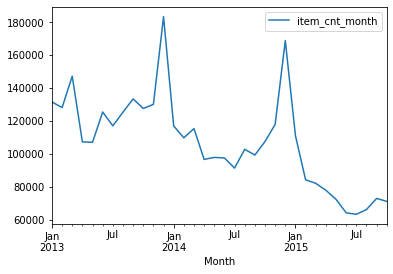

In [74]:
salesPerMonth = sales.groupby(['Month']).agg({'item_cnt_day' : 'sum'})
salesPerMonth.reset_index(inplace=True)
salesPerMonth = salesPerMonth.set_index('Month')
salesPerMonth.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
salesPerMonth.plot()

#### 5. Time Series Analysis

##### 5.1 Time Series Decomposition

-> To obeserve underlying patterns such as trend, seasonality, cycle and irregular remainder

In [91]:
salesPerMonth.item_cnt_month.values

array([131479., 128090., 147142., 107190., 106970., 125381., 116966.,
       125291., 133332., 127541., 130009., 183342., 116899., 109687.,
       115297.,  96556.,  97790.,  97429.,  91280., 102721.,  99208.,
       107422., 117845., 168755., 110971.,  84198.,  82014.,  77827.,
        72295.,  64114.,  63187.,  66079.,  72843.,  71056.],
      dtype=float32)

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose

salesPerMonth.item_cnt_month.interpolate(inplace = True)
# salesPerMonth.item_cnt_month.index=salesPerMonth.item_cnt_month.index.to_timestamp()
decompose = seasonal_decompose(salesPerMonth.item_cnt_month,model='multiplicative', extrapolate_trend=8)
# decompose = seasonal_decompose(salesPerMonth.item_cnt_month,model='multiplicative', extrapolate_trend=8)

Text(0.5, 0.98, 'Decomposition of Time Series')

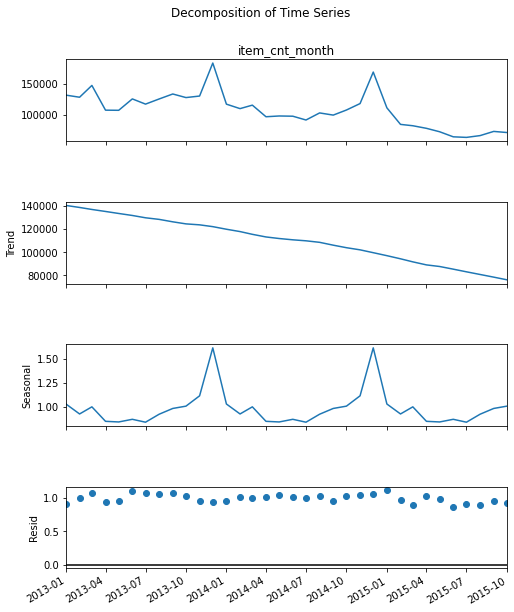

In [113]:
fig = decompose.plot()
fig.set_figheight(10)
fig.set_figwidth(8)
fig.autofmt_xdate(rotation=30)
fig.suptitle('Decomposition of Time Series')

##### 5.2 Check stationarity

In [136]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, period = 12, dft=False):
    movingAVG = df.rolling(window=period).mean()
    movingSTD = df.rolling(window=period).std()
    #plot
    plt.figure(figsize=(15, 10))
    orig = plt.plot(df, color='blue', label='Original', alpha=0.3)
    mean = plt.plot(movingAVG, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling  Standard Deviation', alpha=0.5)
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    if dft:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(df, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['\nCritical Value (%s)' % key] = value
        print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
\nCritical Value (1%)          -3.646135
\nCritical Value (5%)          -2.954127
\nCritical Value (10%)         -2.615968
dtype: float64


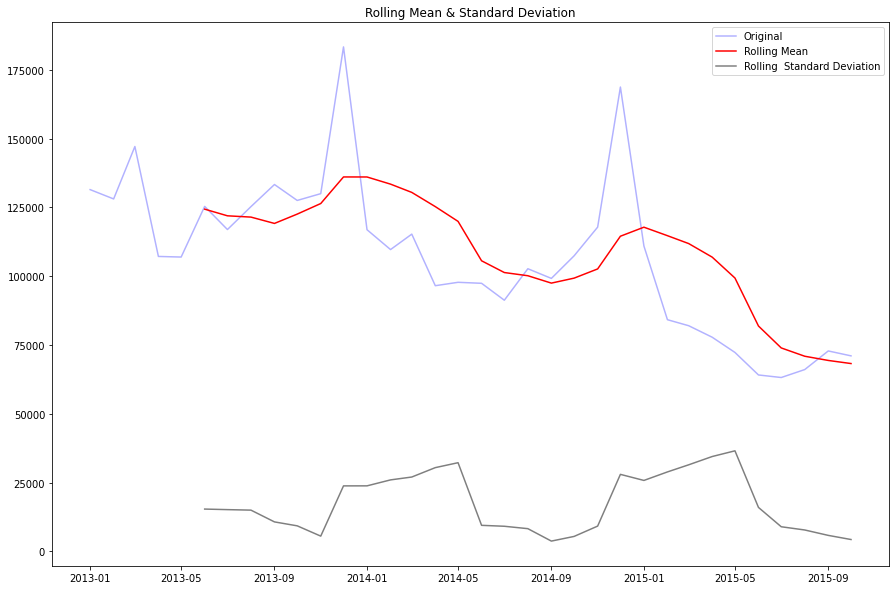

In [139]:
test_stationarity(salesPerMonth['item_cnt_month'], 6, True)

#### 6. Model Fitting

##### 6.1 Train test split

##### 6.2 ARIMA

##### 6.3 Auto ARIMA + SHIFT

#### 7. Prediction and validation

#### 8. Submission